In [1]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Reshape, Dropout, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model

Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
# command line flags
flags.DEFINE_integer('epochs', 10, "The number of epochs.")

In [3]:
# read csv
lines = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skip header
    for line in reader:
        lines.append(line)

In [4]:
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [5]:
# define generator to read images
def generator(samples, batch_size):
    source_path = './IMG/'
    correction = .15
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
       samples = shuffle(samples)
       for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset : offset + batch_size]
            images = []
            measurements = []
            for batch_sample in batch_samples:
                cName = source_path + batch_sample[0].split('/')[-1]
                cImage = cv2.imread(cName)
                cMeasurement = float(batch_sample[3])
                images.append(cImage)
                measurements.append(cMeasurement)

                lName = source_path + batch_sample[1].split('/')[-1]
                lImage = cv2.imread(lName)
                lMeasurement = cMeasurement + correction
                images.append(lImage)
                measurements.append(lMeasurement)

                rName = source_path + batch_sample[2].split('/')[-1]
                rImage = cv2.imread(rName)
                rMeasurement = cMeasurement - correction
                images.append(rImage)
                measurements.append(rMeasurement)

                cImage_aug = cv2.flip(cImage, 1)
                images.append(cImage_aug)
                measurements.append(-cMeasurement)

            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            print(cName)

In [6]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [7]:
# define the model
model = Sequential()
# Preprocess incoming data, centered around zero with std
model.add(Cropping2D(cropping=((60, 24), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(160, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.4))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.4))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.4))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.4))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.9))
model.add(Dense(1))

model.summary()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
    len(train_samples) * 4, validation_data=validation_generator, 
    nb_val_samples=len(validation_samples), nb_epoch=FLAGS.epochs, verbose=1)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 76, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 76, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 36, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

dict_keys(['val_loss', 'loss'])


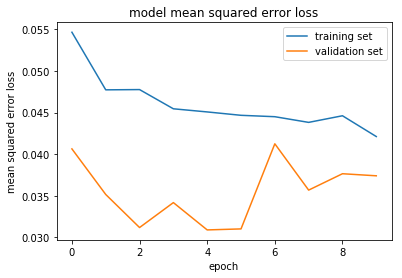

In [8]:
# print the keys contained in the history object
print(history_object.history.keys())

# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()